# Classifying names with a character level RNN
we will buuild and train a basic character level RNN so as to classfiy words. A character-level RNN reads words as series of characters-outputting a predction and hidden state at each state. 

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open 
import glob 
import os

In [3]:
def findFiles(path):
    return glob.glob(path)
print(findFiles('data/names/*.txt'))

['data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Russian.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Chinese.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt']


In [4]:
import unicodedata
import string

In [6]:
all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)
n_letters

56

In [8]:
#turn a unicode string to plain ASCII 
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [11]:
# build the category_lines dictionary, a list of names per language 
category_lines = {}
all_categories = []


In [16]:
# read a file and split into lines 
def readLines(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [19]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# Tensoring

In [20]:
import torch 

In [21]:
# find letter index from all_letters e.g. "a"=0
def letterToIndex(letter):
    return all_letters.find(letter)

In [22]:
# just for demonstration, turna letter into a <1 x n_letters> tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [24]:
# turn a line into a <line_length x 1 x n_letters>
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


# The Network

In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden),1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128 
rnn = RNN(n_letters, n_hidden, n_categories)

In [26]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [27]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-4.5993, -4.4781, -4.5394, -4.5135, -4.4901, -4.4754, -4.4634, -4.5495,
         -4.5020, -4.4541, -4.4472, -4.4134, -4.4810, -4.4794, -4.3953, -4.5835,
         -4.5299, -4.4436, -4.4269, -4.5931, -4.5380, -4.5474, -4.4301, -4.5450,
         -4.5239, -4.5026, -4.5475, -4.3960, -4.4237, -4.5589, -4.5682, -4.4009,
         -4.5023, -4.5279, -4.5071, -4.4991, -4.6321, -4.6006, -4.4927, -4.5936,
         -4.5649, -4.4286, -4.5457, -4.4979, -4.5659, -4.4036, -4.4951, -4.5450,
         -4.5729, -4.5292, -4.3895, -4.4629, -4.5873, -4.4409, -4.5072, -4.4192,
         -4.5848, -4.5284, -4.4283, -4.5069, -4.4286, -4.4896, -4.5211, -4.4521,
         -4.4650, -4.3833, -4.4914, -4.4856, -4.4716, -4.4385, -4.4729, -4.4210,
         -4.5761, -4.5340, -4.5851, -4.4759, -4.4894, -4.5260, -4.4831, -4.5799,
         -4.4180, -4.4093, -4.5140, -4.5379, -4.5244, -4.6102, -4.5645, -4.5207,
         -4.5529, -4.5225]], grad_fn=<LogSoftmaxBackward0>)


# Training
## Preparing for training 

In [29]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('French', 65)


In [33]:
import random  

def randomChoice(l):
    return l[random.randint(0, len(l) -1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Greek / line = Pispinis
category = Polish / line = Marszaek
category = Greek / line = Louverdis
category = Japanese / line = Takagaki
category = English / line = Kidner
category = Dutch / line = Penders
category = French / line = Monette
category = French / line = Glaisyer
category = Vietnamese / line = Tron
category = Chinese / line = Loong


## Training the network

In [34]:
criterion = nn.NLLLoss()

In [35]:
lr = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # add parameters' gradients to tehir values, multiplied by lr 
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
        
    return output, loss.item()

In [37]:
import time 
import math 

n_iters = 100000
print_every = 5000 
plot_every = 1000

# keep track of losses for plotting 
current_loss = 0 
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m* 60 
    return '%dm %ds' % (m,s)

start = time.time()

for iter in range(1, n_iters +1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    #print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
        #add current loss avg to list of losses 
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

5000 5% (0m 8s) 3.3898 Ola / Chinese ✗ (Spanish)
10000 10% (0m 17s) 1.7707 Oquendo / Italian ✗ (Spanish)
15000 15% (0m 25s) 2.8700 Zaruba / Japanese ✗ (Czech)
20000 20% (0m 34s) 2.8164 Gaspar / Arabic ✗ (Portuguese)
25000 25% (0m 43s) 3.4401 Albuquerque / Irish ✗ (Portuguese)
30000 30% (0m 55s) 0.5688 Ricci / Italian /
35000 35% (1m 8s) 4.1272 Baum / Vietnamese ✗ (German)
40000 40% (1m 19s) 1.8887 Como / Japanese ✗ (Italian)
45000 45% (1m 28s) 1.1672 Sortras / Portuguese ✗ (Greek)
50000 50% (1m 37s) 0.4424 Mikolajczak / Polish /
55000 55% (1m 46s) 1.0996 Halabi / Arabic /
60000 60% (1m 56s) 2.0970 Campo / Italian ✗ (Spanish)
65000 65% (2m 7s) 1.4252 Kacirek / Portuguese ✗ (Czech)
70000 70% (2m 18s) 0.8958 Metzger / German /
75000 75% (2m 29s) 0.8939 Knochenmus / German /
80000 80% (2m 39s) 0.4361 Wawrzaszek / Polish /
85000 85% (2m 49s) 0.3737 Parisi / Italian /
90000 90% (3m 0s) 0.5347 Ma / Korean /
95000 95% (3m 11s) 1.4496 Jewitt / English /
100000 100% (3m 22s) 0.7667 Nakanoi / Jap

# Plotting the results


In [38]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

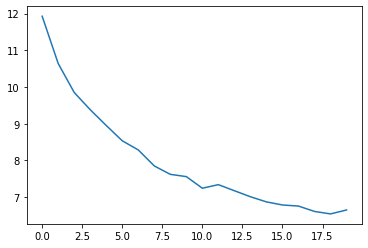

In [39]:
plt.figure()
plt.plot(all_losses)